In [12]:
import sys

import numpy as np
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
import matplotlib.pyplot as plt
from cfilt.utils import *

In [3]:
ds = CDS(
    [4, 16, 1600],
    "jx",
    "../out/",
    normalize=True,
    # transform=transforms.ToTensor(),
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def anisodiff(
    img, niter=1, kappa=50, gamma=0.1, step=(1.0, 1.0), option=1, ploton=False
):
    """
    Anisotropic diffusion.

    Usage:
    imgout = anisodiff(im, niter, kappa, gamma, option)

    Arguments:
        img    - input image
        niter  - number of iterations
        kappa  - conduction coefficient 20-100
        gamma  - max value of .25 for stability
        step   - tuple, the distance between adjacent pixels in (y,x)
        option - 1 Perona Malik diffusion equation No 1
                 2 Perona Malik diffusion equation No 2
        ploton - if True, the image will be plotted on every iteration

    Returns:
        imgout   - diffused image.

    kappa controls conduction as a function of gradient.  If kappa is low
    small intensity gradients are able to block conduction and hence diffusion
    across step edges.  A large value reduces the influence of intensity
    gradients on conduction.

    gamma controls speed of diffusion (you usually want it at a maximum of
    0.25)

    step is used to scale the gradients in case the spacing between adjacent
    pixels differs in the x and y axes

    Diffusion equation 1 favours high contrast edges over low contrast ones.
    Diffusion equation 2 favours wide regions over smaller ones.

    Reference:
    P. Perona and J. Malik.
    Scale-space and edge detection using ansotropic diffusion.
    IEEE Transactions on Pattern Analysis and Machine Intelligence,
    12(7):629-639, July 1990.

    Original MATLAB code by Peter Kovesi
    School of Computer Science & Software Engineering
    The University of Western Australia
    pk @ csse uwa edu au
    <http://www.csse.uwa.edu.au>

    Translated to Python and optimised by Alistair Muldal
    Department of Pharmacology
    University of Oxford
    <alistair.muldal@pharm.ox.ac.uk>

    June 2000  original version.
    March 2002 corrected diffusion eqn No 2.
    July 2012 translated to Python
    """

    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype("float32")
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    # create the plot figure, if requested
    if ploton:
        from time import sleep

        import pylab as pl

        fig = pl.figure(figsize=(20, 5.5), num="Anisotropic diffusion")
        ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)

        ax1.imshow(img, interpolation="nearest")
        ih = ax2.imshow(imgout, interpolation="nearest", animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in tqdm(range(niter)):

        # calculate the diffs
        deltaS[:-1, :] = np.diff(imgout, axis=0)
        deltaE[:, :-1] = np.diff(imgout, axis=1)

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-((deltaS / kappa) ** 2.0)) / step[0]
            gE = np.exp(-((deltaE / kappa) ** 2.0)) / step[1]
        elif option == 2:
            gS = 1.0 / (1.0 + (deltaS / kappa) ** 2.0) / step[0]
            gE = 1.0 / (1.0 + (deltaE / kappa) ** 2.0) / step[1]

        # update matrices
        E = gE * deltaE
        S = gS * deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        # update the image
        imgout += gamma * (NS + EW)

        if ploton:
            iterstring = "Iteration %i" % (ii + 1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout

In [16]:
x4, x16, x1600 = ds[10]

In [39]:
from scipy.ndimage import gaussian_filter

  0%|          | 0/5 [00:00<?, ?it/s]

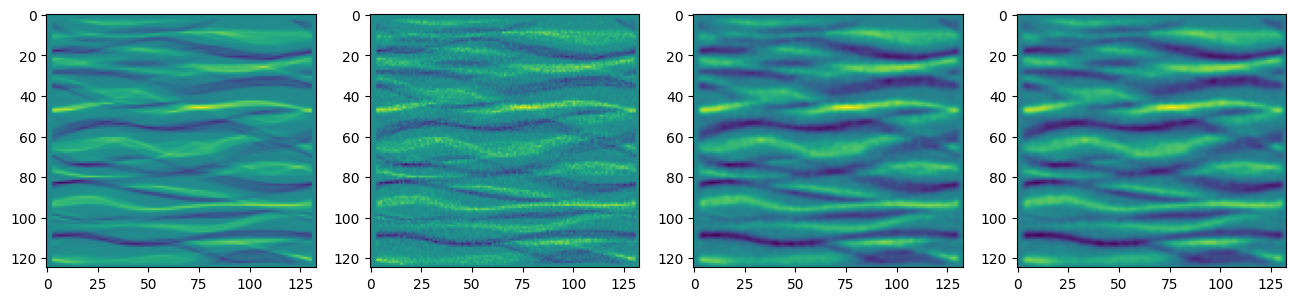

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
x4o = anisodiff(x4, niter=5, option=1)
ax[0].imshow(x1600)
ax[1].imshow(x4)
ax[2].imshow(x4o)
ax[3].imshow(gaussian_filter(x4o, sigma=.5))
# ax[3].imshow(0.1 * x4 + 0.9 * x4o)